In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler
from plotting.learning_curves import loss_plot

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assess performance of base and MC-dropout models on left out test set 

#### Set variables

In [35]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)
# older baseline: 20180308_12_04_41_dcnnv1_150000E_lr2e02
# newest baseline: 20180319_10_49_05_dcnnv1_150000E_lr2e02
exp_base_model = os.path.join(LOG_DIR, "20180319_10_49_05_dcnnv1_150000E_lr2e02")
exp_mc005_model = os.path.join(LOG_DIR, "20180320_17_39_16_dcnn_mcv1_150000E_lr2e02")
exp_mc01_model = os.path.join(LOG_DIR, "20180317_17_34_02_dcnn_mcv1_150000E_lr2e02")
exp_mc025_model = os.path.join(LOG_DIR, "20180318_16_31_57_dcnn_mcv1_150000E_lr2e02")
# 20180308_12_05_35_dcnn_mcv1_150000E_lr2e02 p=0.1
# mix model with 0.1 and 0.2 (deeper layers) drop out
exp_mc_mix_model = os.path.join(LOG_DIR, "20180317_17_42_52_dcnn_mc_mixv1_150000E_lr2e02")
# mc-drop 0.1 with brier-score as loss function
exp_mc01_bs_model = "20180320_10_14_08_dcnn_mcv1_150000E_lr2e04"


## Load experimental data and test data set

In [3]:
exper_base = ExperimentHandler.load_experiment(exp_base_model)
exper_hdl_base = ExperimentHandler(exper_base, use_logfile=False)
exper_hdl_base.set_root_dir(ROOT_DIR)

exper_mc005 = ExperimentHandler.load_experiment(exp_mc005_model)
exper_hdl_mc005 = ExperimentHandler(exper_mc005, use_logfile=False)
exper_hdl_mc005.set_root_dir(ROOT_DIR)

exper_mc01 = ExperimentHandler.load_experiment(exp_mc01_model)
exper_hdl_mc01 = ExperimentHandler(exper_mc01, use_logfile=False)
exper_hdl_mc01.set_root_dir(ROOT_DIR)

exper_mc025 = ExperimentHandler.load_experiment(exp_mc025_model)
exper_hdl_mc025 = ExperimentHandler(exper_mc025, use_logfile=False)
exper_hdl_mc025.set_root_dir(ROOT_DIR)

exper_mc_mix = ExperimentHandler.load_experiment(exp_mc_mix_model)
exper_hdl_mc_mix = ExperimentHandler(exper_mc_mix, use_logfile=False)
exper_hdl_mc_mix.set_root_dir(ROOT_DIR)

exp_hdl_mc01_bs = ExperimentHandler.load_experiment(exp_mc01_bs_model)
exp_hdl_mc01_bs = ExperimentHandler(exp_hdl_mc01_bs, use_logfile=False)
exp_hdl_mc01_bs.set_root_dir(ROOT_DIR)

test_set = ACDC2017TestHandler(exper_config=exper_hdl_base.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[3],
                               debug=False, batch_size=20, use_cuda=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Load from /home/jorg/repository/dcnn_acdc/logs/20180319_10_49_05_dcnnv1_150000E_lr2e02/stats/exper_stats.dll
Load from /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Load from /home/jorg/repository/dcnn_acdc/logs/20180318_16_31_57_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Load from /home/jorg/repository/dcnn_acdc/logs/20180317_17_42_52_dcnn_mc_mixv1_150000E_lr2e02/stats/exper_stats.dll
Load from /home/jorg/repository/dcnn_acdc/logs/20180320_10_14_08_dcnn_mcv1_150000E_lr2e04/stats/exper_stats.dll
INFO - Testhandler - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/*patient*.mhd <<<
INFO - File list contains 200 files
0 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient006_frame01.mhd
1 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient006_frame16.mhd


  5%|▌         | 1/20 [00:00<00:18,  1.04it/s]

2 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient007_frame01.mhd
3 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient007_frame07.mhd


 10%|█         | 2/20 [00:01<00:15,  1.15it/s]/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


4 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient008_frame01.mhd
5 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient008_frame13.mhd


 15%|█▌        | 3/20 [00:02<00:13,  1.30it/s]

6 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient009_frame01.mhd
7 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient009_frame13.mhd


 20%|██        | 4/20 [00:02<00:11,  1.44it/s]

8 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient010_frame01.mhd
9 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient010_frame13.mhd


 25%|██▌       | 5/20 [00:03<00:10,  1.48it/s]

10 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient011_frame01.mhd
11 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient011_frame08.mhd


 30%|███       | 6/20 [00:03<00:09,  1.54it/s]

12 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient012_frame01.mhd
13 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient012_frame13.mhd


 35%|███▌      | 7/20 [00:04<00:08,  1.58it/s]

14 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient013_frame01.mhd
15 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient013_frame14.mhd


 40%|████      | 8/20 [00:04<00:07,  1.61it/s]

16 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient014_frame01.mhd
17 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient014_frame13.mhd


 45%|████▌     | 9/20 [00:05<00:06,  1.65it/s]

18 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient015_frame01.mhd
19 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient015_frame10.mhd


 50%|█████     | 10/20 [00:05<00:05,  1.69it/s]

20 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient016_frame01.mhd
21 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient016_frame12.mhd


 55%|█████▌    | 11/20 [00:06<00:05,  1.72it/s]

22 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient017_frame01.mhd
23 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient017_frame09.mhd


 60%|██████    | 12/20 [00:06<00:04,  1.72it/s]

24 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient018_frame01.mhd
25 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient018_frame10.mhd


 65%|██████▌   | 13/20 [00:07<00:04,  1.74it/s]

26 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient019_frame01.mhd
27 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient019_frame11.mhd


 70%|███████   | 14/20 [00:08<00:03,  1.74it/s]

28 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient020_frame01.mhd
29 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient020_frame11.mhd


 75%|███████▌  | 15/20 [00:08<00:02,  1.73it/s]

30 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient026_frame01.mhd
31 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient026_frame12.mhd


 80%|████████  | 16/20 [00:09<00:02,  1.75it/s]

32 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient027_frame01.mhd
33 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient027_frame11.mhd


 85%|████████▌ | 17/20 [00:09<00:01,  1.76it/s]

34 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient028_frame01.mhd
35 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient028_frame09.mhd


 90%|█████████ | 18/20 [00:10<00:01,  1.75it/s]

36 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient029_frame01.mhd
37 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient029_frame12.mhd


 95%|█████████▌| 19/20 [00:10<00:00,  1.76it/s]

38 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient030_frame01.mhd
39 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient030_frame12.mhd


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]

INFO - Successfully loaded 20 ED/ES patient pairs


## Run model evaluation of test set

In [4]:
def test_ensemble(test_set, exper_hdl, mc_samples=10, sample_weights=True, use_uncertainty=False,
                 std_threshold=None, image_range=None, verbose=False, reset_results=False, 
                  store_details=False, generate_stats=False, save_results=False):
    # checkpoints = np.arange(CYCLE_OFFSET, 150001, 10000)
    checkpoints = [150000]
    # checkpoints = [10000, 50000, 100000, 150000]
    if reset_results:
        exper_hdl.reset_results()
    
    if use_uncertainty:
        print("INFO - Using {:.2f} as uncertainty threshold".format(std_threshold))
    for checkpoint in checkpoints:
        dcnn_model = exper_hdl.load_checkpoint(verbose=False, drop_prob=exper_hdl.exper.run_args.drop_prob, 
                                               checkpoint=checkpoint)
        if image_range is None:
            image_range = np.arange(len(test_set.images))
        num_of_images = len(image_range)
        print("INFO - Running test on {} images".format(num_of_images))
        for image_num in image_range:
            exper_hdl.test(dcnn_model, test_set, image_num=image_num, sample_weights=sample_weights, 
                           mc_samples=mc_samples, compute_hd=True, use_uncertainty=use_uncertainty, 
                           std_threshold=std_threshold, verbose=verbose, store_details=store_details)
        del dcnn_model
    exper_hdl.test_results.compute_mean_stats()
    exper_hdl.test_results.show_results()
    
    if generate_stats:
        print("INFO - generating statistics for {} run(s). May take a while".format(exper_hdl.test_results.N))
        exper_hdl.test_results.generate_all_statistics()
    if save_results:
        exper_hdl.test_results.save_results()

# None means all test images will be evaluated
image_range = None

In [ ]:
mc_samples = 25
sample_weights = True
store_details = False
image_range = None  # [1, 9, 19]
generate_stats = False
save_results = False
exper_hdl_base.logger = None

test_ensemble(test_set, exper_hdl_base, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=False, 
              std_threshold=0., image_range=image_range, verbose=False, reset_results=True, 
              store_details=store_details, generate_stats=generate_stats, save_results=save_results)


    
print("Ready")

In [79]:
sample_weights = False
mc_samples = 1
store_details = True
image_range = [19]  # [1, 9, 19]
generate_stats = True

save_results = False
 #  exper_hdl_mc01 exper_hdl_mc025 exp_hdl_mc01_bs
exp_hdl_mc01_bs.logger = None

test_ensemble(test_set, exp_hdl_mc01_bs, mc_samples=mc_samples, sample_weights=sample_weights,
              use_uncertainty=False, 
              std_threshold=0., image_range=image_range, verbose=False, reset_results=True, 
              store_details=store_details, generate_stats=generate_stats, save_results=save_results)


    
print("Ready")


INFO - Running test on 1 images
Image 20 - Test accuracy: test loss -1.175	 dice(RV/Myo/LV): ES 0.55/0.94/0.79 --- ED 0.88/0.89/0.92
Image 20 - Test accuracy: test loss -1.175	 Hausdorff(RV/Myo/LV): ES 22.32/10.10/18.09 --- ED 11.80/27.61/31.34
Test accuracy: 	 dice(RV/Myo/LV): ES 0.55 (0.00)/0.94 (0.00)/0.79 (0.00) --- ED 0.88 (0.00)/0.89 (0.00)/0.92 (0.00)
Test accuracy: 	 Hausdorff(RV/Myo/LV): ES 22.32 (0.00)/10.10 (0.00)/18.09 (0.00) --- ED 11.80 (0.00)/27.61 (0.00)/31.34 (0.00)
INFO - generating statistics for 1 run(s). May take a while
Ready


# Compare performance of models

In [ ]:
exper_hdl_base.logger = None
generate_stats = False

test_ensemble(test_set, exper_hdl_base, mc_samples=1, sample_weights=False, image_range=image_range, verbose=False,
              use_uncertainty=False, reset_results=True)

if generate_stats:
    print("INFO - generating statistics for {} runs. May take a while".format(exper_hdl_base.test_results.N))
    exper_hdl_base.test_results.generate_all_statistics()
print("Ready")


In [13]:
exper_hdl_base.test_results.show_results()

Test accuracy: 	 dice(RV/Myo/LV): ES 0.86 (0.09)/0.87 (0.03)/0.92 (0.08) --- ED 0.92 (0.03)/0.87 (0.03)/0.96 (0.01)
Test accuracy: 	 Hausdorff(RV/Myo/LV): ES 21.40 (16.25)/31.23 (44.79)/10.76 (6.12) --- ED 25.29 (21.49)/58.11 (54.90)/24.59 (35.83)


In [14]:
exper_hdl_mc01.test_results.generate_all_statistics()

ES correct/error(fp+fn) (568450,) / (10722,)
ED correct/error(fp+fn) (562626,) / (11738,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180320_17_39_16_dcnn_mcv1_150000E_lr2e02/figures/patient030_frame01_frame12probs_densities_s25_False.png


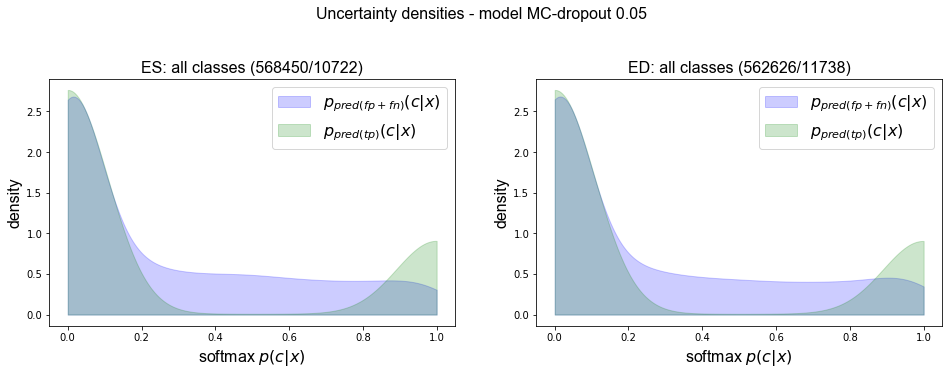

In [52]:
# info_type="uncertainty"  or probabilities
# model_names a) "Baseline with p=0.5" b) MC-dropout 0.1  c) MC-dropout-Brier 0.1 
handler = exper_hdl_mc005 # exper_hdl_mc01   exper_hdl_base  exp_hdl_mc01_bs  exper_hdl_mc005
handler.test_results.visualize_uncertainty_stats(image_num=0, width=16, height=10, info_type="probs",
                                                     do_save=True, model_name="MC-dropout 0.05")

In [80]:
# model_name a) Baseline  b) MC-dropout 0.1
handler = exp_hdl_mc01_bs  #  exper_hdl_mc01  exper_hdl_base  exp_hdl_mc01_bs
handler.test_results.visualize_uncertainty_histograms(image_num=0, width=20, height=35, info_type="stddev",
                                                             do_save=True, slice_range=None,
                                                             std_threshold=0., errors_only=True, 
                                                             do_show=False,
                                                             model_name = "MC-dropout-Brier (0.1)")
                                                             # model_name="MC-dropout (0.1)")
# WARNING - RV-errors using 0.25 before/after 432 / 6
# WARNING - RV-errors using 0.25 before/after 1250 / 228
# WARNING - RV-errors using 0.25 before/after 599 / 333
# WARNING - RV-errors using 0.25 before/after 177 / 213
# WARNING - RV-errors using 0.25 before/after 87 / 80
# WARNING - RV-errors using 0.25 before/after 201 / 173

INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180320_10_14_08_dcnn_mcv1_150000E_lr2e04/figures/patient030_frame01_frame12_seg_errors_0_1_2_3_4_5_6_7_8_9_s1_True.png


In [ ]:
exper_hdl_mc01.test_results.visualize_test_slices(width=20, height=80, slice_range=[0, 5],
                                               do_save=False, image_num=0)

Number of subplots 50 columns 5 rows 2 slices 0,1,5,8,9
Slice 1 - ES - Class 1: errors 516 || dice 1.00 || hd  0.00
Slice 1 - ES - Class 2: errors 1634 || dice 0.99 || hd  0.00
Slice 1 - ES - Class 3: errors 866 || dice 1.00 || hd  0.00
Slice 1 - ED - Class 1: errors 2314 || dice 0.99 || hd  0.00
Slice 1 - ED - Class 2: errors 1832 || dice 0.99 || hd  0.00
Slice 1 - ED - Class 3: errors 1610 || dice 0.99 || hd  0.00
Slice 2 - ES - Class 1: errors 903 || dice 1.00 || hd  0.00
Slice 2 - ES - Class 2: errors 1041 || dice 0.60 || hd  193.04
Slice 2 - ES - Class 3: errors 516 || dice 0.81 || hd  17.93
Slice 2 - ED - Class 1: errors 2605 || dice 0.99 || hd  0.00
Slice 2 - ED - Class 2: errors 718 || dice 0.72 || hd  191.06
Slice 2 - ED - Class 3: errors 346 || dice 0.91 || hd  56.03
Slice 6 - ES - Class 1: errors 142 || dice 0.95 || hd  8.85
Slice 6 - ES - Class 2: errors 434 || dice 0.82 || hd  157.80
Slice 6 - ES - Class 3: errors 170 || dice 0.96 || hd  18.68
Slice 6 - ED - Class 1: error

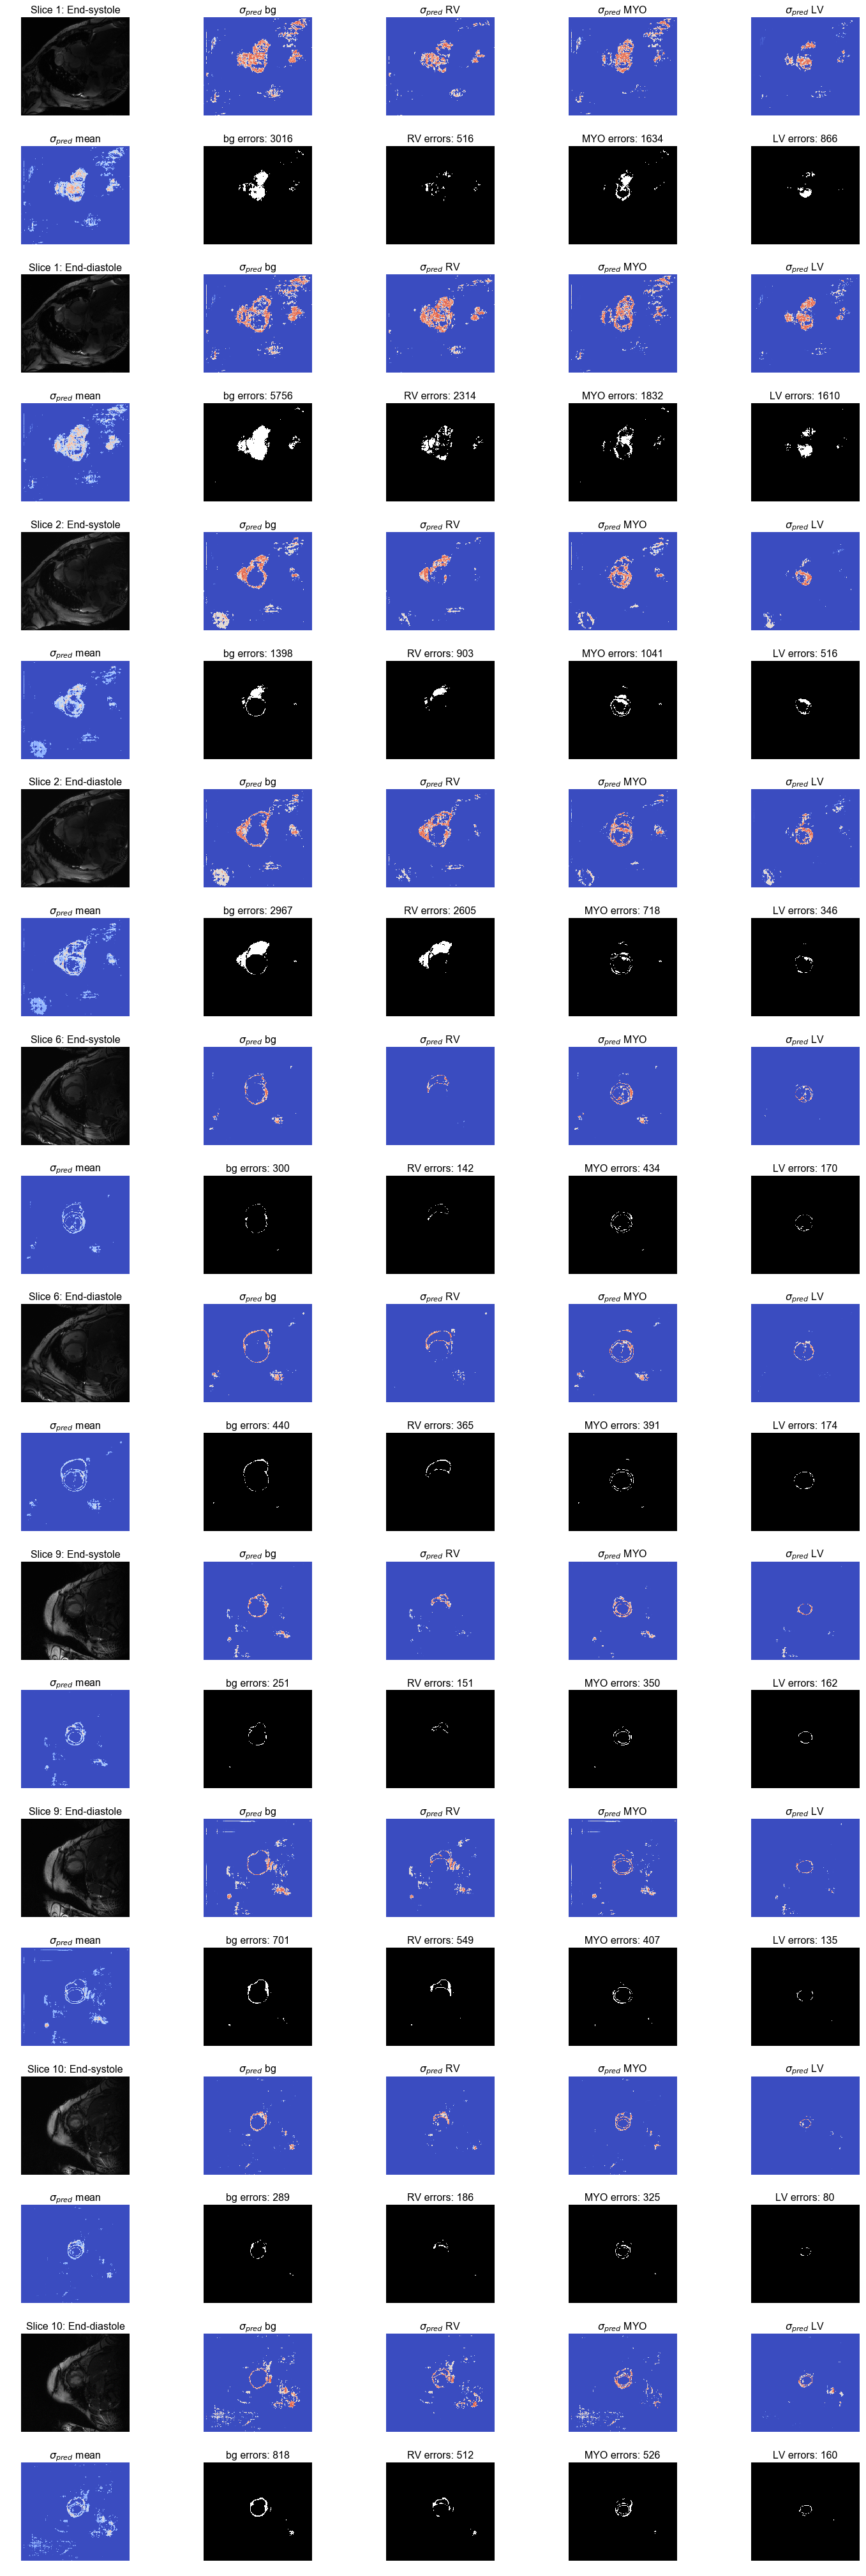

In [9]:
exper_hdl_mc.test_results.visualize_prediction_uncertainty(width=20, height=140, slice_range=[0, 1, 5 ,8, 9], 
                                                           do_save=True, std_threshold=None, 
                                                           image_num=0)

Number of subplots 30 columns 5 rows 2 slices 0,1,2
Slice 1 - ES - Class 1: errors 0 || dice 1.00 || hd  0.00
Slice 1 - ES - Class 2: errors 311 || dice 0.85 || hd  17.03
Slice 1 - ES - Class 3: errors 254 || dice 0.91 || hd  22.40
Slice 1 - ED - Class 1: errors 0 || dice 1.00 || hd  0.00
Slice 1 - ED - Class 2: errors 385 || dice 0.83 || hd  49.97
Slice 1 - ED - Class 3: errors 175 || dice 0.95 || hd  46.05
Slice 2 - ES - Class 1: errors 5 || dice 0.00 || hd  0.00
Slice 2 - ES - Class 2: errors 311 || dice 0.85 || hd  4.43
Slice 2 - ES - Class 3: errors 134 || dice 0.96 || hd  3.96
Slice 2 - ED - Class 1: errors 207 || dice 0.96 || hd  14.28
Slice 2 - ED - Class 2: errors 236 || dice 0.88 || hd  5.60
Slice 2 - ED - Class 3: errors 78 || dice 0.98 || hd  2.80
Slice 3 - ES - Class 1: errors 163 || dice 0.96 || hd  10.66
Slice 3 - ES - Class 2: errors 229 || dice 0.91 || hd  3.13
Slice 3 - ES - Class 3: errors 83 || dice 0.98 || hd  2.80
Slice 3 - ED - Class 1: errors 185 || dice 0.96 ||

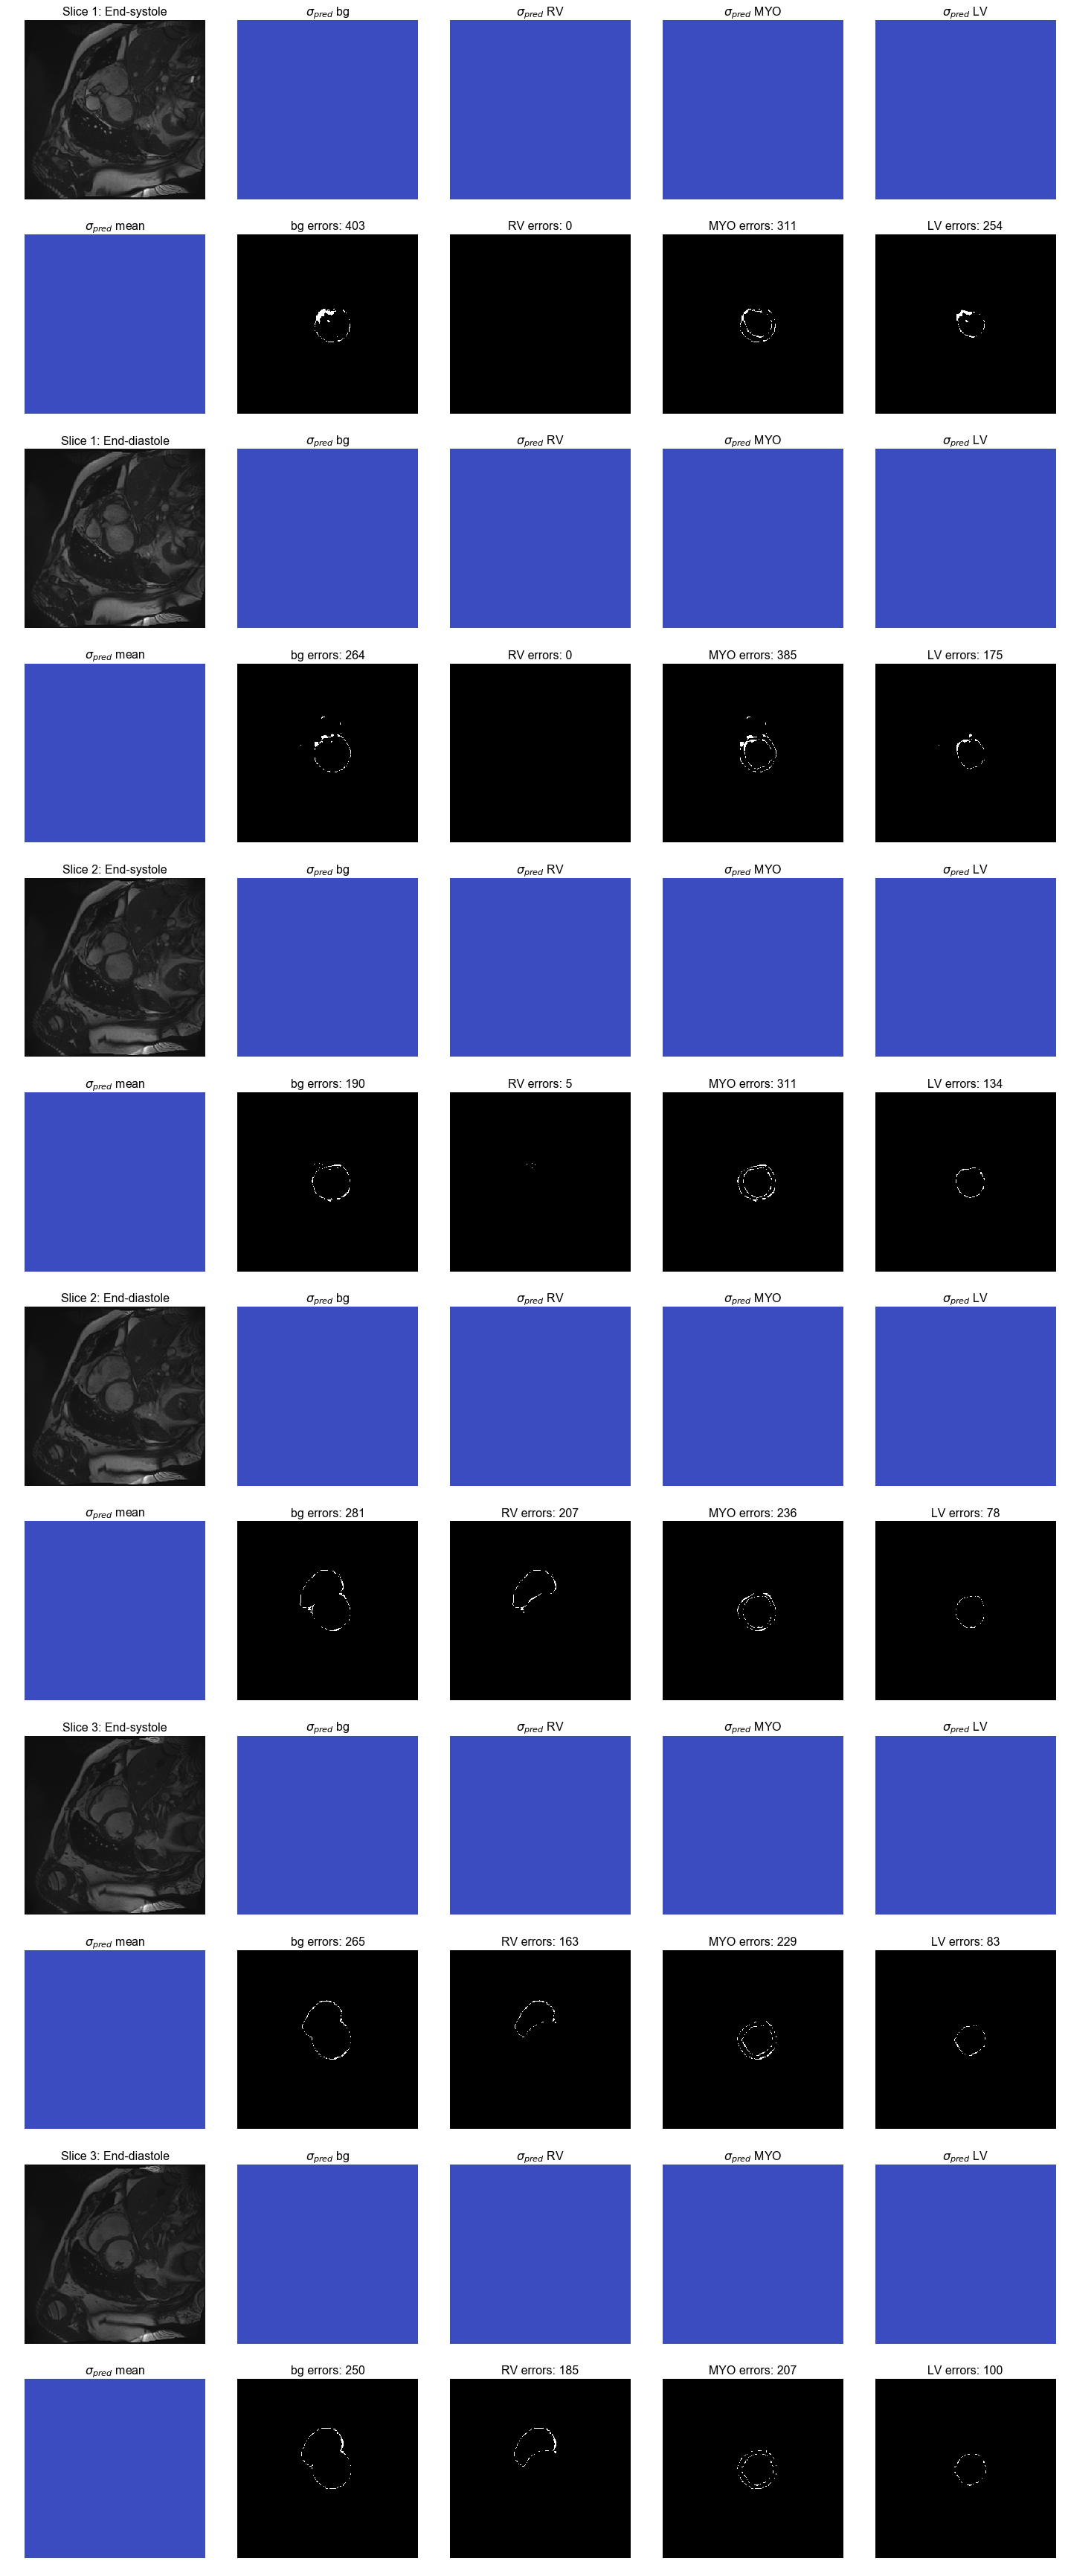

In [85]:
exper_hdl_base.test_results.visualize_prediction_uncertainty(width=20, height=120, slice_range=[0, 1, 2], 
                                                            do_save=False, std_threshold=None)

In [15]:
append_to_dir = os.path.join(exper_hdl_mc.exper.config.root_dir, exper_hdl_mc.exper.output_dir)
exper_hdl_mc.test_results.save_results()

Random number 815
INFO - Saved results to /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/stats/test_results_2018_03_15_08_35.dll


In [9]:
from utils.test_results import TestResults
save_path = os.path.join(exper_hdl_mc.exper.config.root_dir, 
                         os.path.join(exper_hdl_mc.exper.output_dir, exper_hdl_mc.exper.config.stats_path))
save_path = os.path.join(save_path, "test_results_950.dll")
test_results = TestResults.load_results(save_path)


Load from /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/stats/test_results_950.dll


In [77]:
test_set.b_image_id

'patient030_frame01_frame12'

In [ ]:
# img_slice_stats = exper_hdl_mc.test_results.image_probs_categorized[0][0]
# print(img_slice_stats["es_mean_cor_p"].shape)
img = exper_hdl_mc.test_results.images[0]
fig = plt.figure(figsize=(12, 10))
img_slice = img[0][:, :, 5]
print(img_slice.shape)
fig, ax2 = plt.subplots(10, sharex=True, figsize=(10,100))
ax2[0].imshow(img_slice, cmap=cm.gray)
plt.show()